<a href="https://colab.research.google.com/github/PetrGavrilin/VKR_URFU/blob/main/VKR_part6_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Рекуррентная нейронная сеть</h1>

In [84]:
# Загрузка необходимых библиотек и функций

import sys
sys.path.append('/content')

from vkr_function import my_features_extraction, print_scores, plot_predict, my_test_train_split, my_test_val_train_split

import os

import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential #Сеть прямого распространения
#Базовые слои для свёрточных сетей
#from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D,  Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Dense, RNN, LSTM, GRU,  Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam # оптимизатор

try:
  from plot_keras_history import show_history, plot_history
except:
  !pip install plot_keras_history
  from plot_keras_history import show_history, plot_history


In [85]:
# Загрузка данных
Y_ = pd.read_csv('/content/flow_rate.csv')
sig_up = pd.read_csv('/content/sig_up.csv')
sig_dw = pd.read_csv('/content/sig_dw.csv')
borders = pd.read_csv('/content/borders.csv').values.tolist()[0]

In [86]:
X = []

for i_x in range(sig_up.shape[0]):
  X_ = [sig_up.iloc[i_x,:], sig_dw.iloc[i_x,:]]
  X_ = list(map(list, zip(*X_)))
  X.append(X_)

X = np.array(X)
X.shape

(3915, 512, 2)

In [87]:
'''X = np.hstack([sig_up, sig_dw])
X.shape

scaler_up = preprocessing.StandardScaler()
X = scaler_up.fit_transform(X)'''


'X = np.hstack([sig_up, sig_dw])\nX.shape\n\nscaler_up = preprocessing.StandardScaler()\nX = scaler_up.fit_transform(X)'

In [88]:
# Разделение на выборки

Y = np.array(Y_['Et'])
input_dim = X.shape[1]

X_train, y_train, i_train, X_val, y_val, i_val, X_test, y_test, i_test =  my_test_val_train_split(X, Y, borders)

In [89]:
# изменение формата данных
X_train = tf.convert_to_tensor(X_train, np.float32)
X_test = tf.convert_to_tensor(X_test, np.float32)
X_val = tf.convert_to_tensor(X_val, np.float32)
y_train = tf.convert_to_tensor(y_train, np.float32)
y_val = tf.convert_to_tensor(y_val, np.float32)
y_test = tf.convert_to_tensor(y_test, np.float32)

In [138]:
# Рекуррентная нейронная сеть

mm = GRU
fa = "relu6"

model = Sequential()
model.add(BatchNormalization(input_shape=(512, 2)))
model.add(mm(64, return_sequences=True, activation=fa, name="layer_1"))
model.add(mm(32, return_sequences=True, activation=fa, name="layer_2"))
#model.add(Dropout(0.05))
model.add(mm(16, activation="tanh", name="layer_3"))
model.add(Dense(1, activation='relu6', name="layer_4"))

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_2 (Bat  (None, 512, 2)            8         
 chNormalization)                                                
                                                                 
 layer_1 (GRU)               (None, 512, 64)           13056     
                                                                 
 layer_2 (GRU)               (None, 512, 32)           9408      
                                                                 
 layer_3 (GRU)               (None, 16)                2400      
                                                                 
 layer_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 24889 (97.22 KB)
Trainable params: 24885 (97.21 KB)
Non-trainable params: 4 (16.00 Byte)
_________________

In [170]:
opt = keras.optimizers.Adam(
  # learning_rate=0.0001
) # оптимизатор

model.save_weights('model.h5') # сохранение весов

# компиляция модели
model.compile(
    optimizer=opt,
    loss='mean_squared_error',
    metrics=[keras.metrics.RootMeanSquaredError(), keras.metrics.R2Score()]
    )

In [92]:
# сброс лучшей модели
try:
    os.remove("/content/Checkpoint_path.keras")
except OSError:
    pass

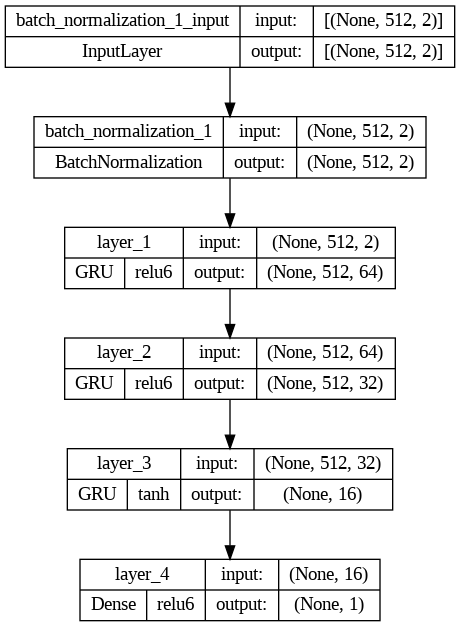

In [93]:
# вывод струтуры модели
keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_activations=True,
    )

In [94]:
# класс обратного вызова
callback_list = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=16,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath="Checkpoint_path.keras",
        nonitor="val_loss",
        save_best_only=True,
    )
]

In [95]:
# Обучение модели
history = model.fit(
    X_train, y_train, epochs=64, batch_size=64,
    callbacks=callback_list, validation_data=(X_val, y_val)
    )

Epoch 1/64
40/40 [==============================] - 38s 833ms/step - loss: 1.3540 - root_mean_squared_error: 1.1636 - r2_score: -1.6153 - val_loss: 0.9396 - val_root_mean_squared_error: 0.9693 - val_r2_score: -0.8214
Epoch 2/64
40/40 [==============================] - 34s 851ms/step - loss: 0.5135 - root_mean_squared_error: 0.7166 - r2_score: 0.0082 - val_loss: 0.6203 - val_root_mean_squared_error: 0.7876 - val_r2_score: -0.2026
Epoch 3/64
40/40 [==============================] - 34s 851ms/step - loss: 0.4315 - root_mean_squared_error: 0.6568 - r2_score: 0.1666 - val_loss: 0.4286 - val_root_mean_squared_error: 0.6547 - val_r2_score: 0.1692
Epoch 4/64
40/40 [==============================] - 34s 843ms/step - loss: 0.3192 - root_mean_squared_error: 0.5650 - r2_score: 0.3834 - val_loss: 0.2623 - val_root_mean_squared_error: 0.5121 - val_r2_score: 0.4916
Epoch 5/64
40/40 [==============================] - 35s 871ms/step - loss: 0.1563 - root_mean_squared_error: 0.3954 - r2_score: 0.6980 - 

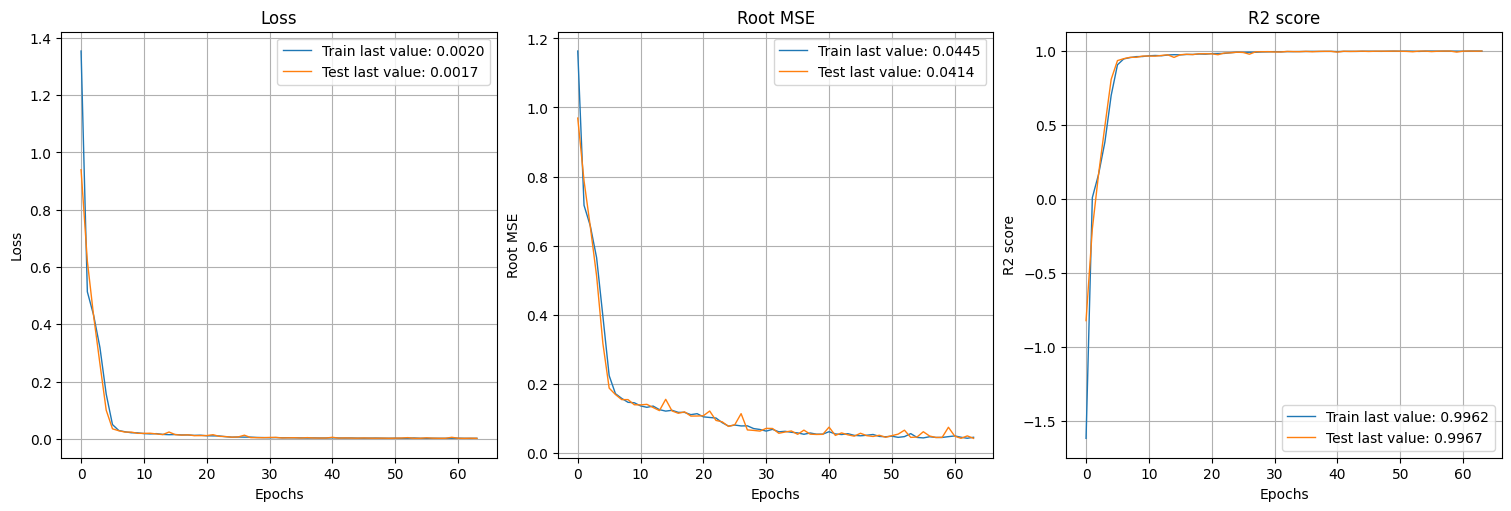

In [96]:
# вывод графиков с изменением метрик
show_history(history)
plot_history(history, path="standard.png")
plt.close()

In [97]:
# предсказание модели на тестовых данных
y_predict = model.predict(X_test)

20/20 [==============================] - 3s 122ms/step


In [98]:
# вывод метрик
print("Тестовая выборка:")
model.evaluate(X_test,y_test)
print("Валидационная выборка:")
model.evaluate(X_val,y_val)
print("Тренировочная выборка:")
model.evaluate(X_train,y_train)
pass

Тестовая выборка:
20/20 [==============================] - 3s 132ms/step - loss: 0.0017 - root_mean_squared_error: 0.0416 - r2_score: 0.9967
Валидационная выборка:
25/25 [==============================] - 3s 121ms/step - loss: 0.0017 - root_mean_squared_error: 0.0414 - r2_score: 0.9967
Тренировочная выборка:
79/79 [==============================] - 11s 139ms/step - loss: 0.0015 - root_mean_squared_error: 0.0389 - r2_score: 0.9971


In [99]:
# предсказание модели на полных данных
y_predict_all = model.predict(X)

123/123 [==============================] - 18s 145ms/step


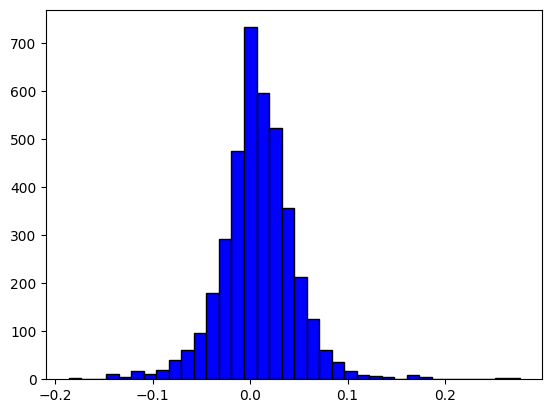

In [100]:
spo  = y_predict_all[:,0]-Y
plt.hist(spo, color = 'blue', edgecolor = 'black',
         bins = int(180/5))
plt.show()

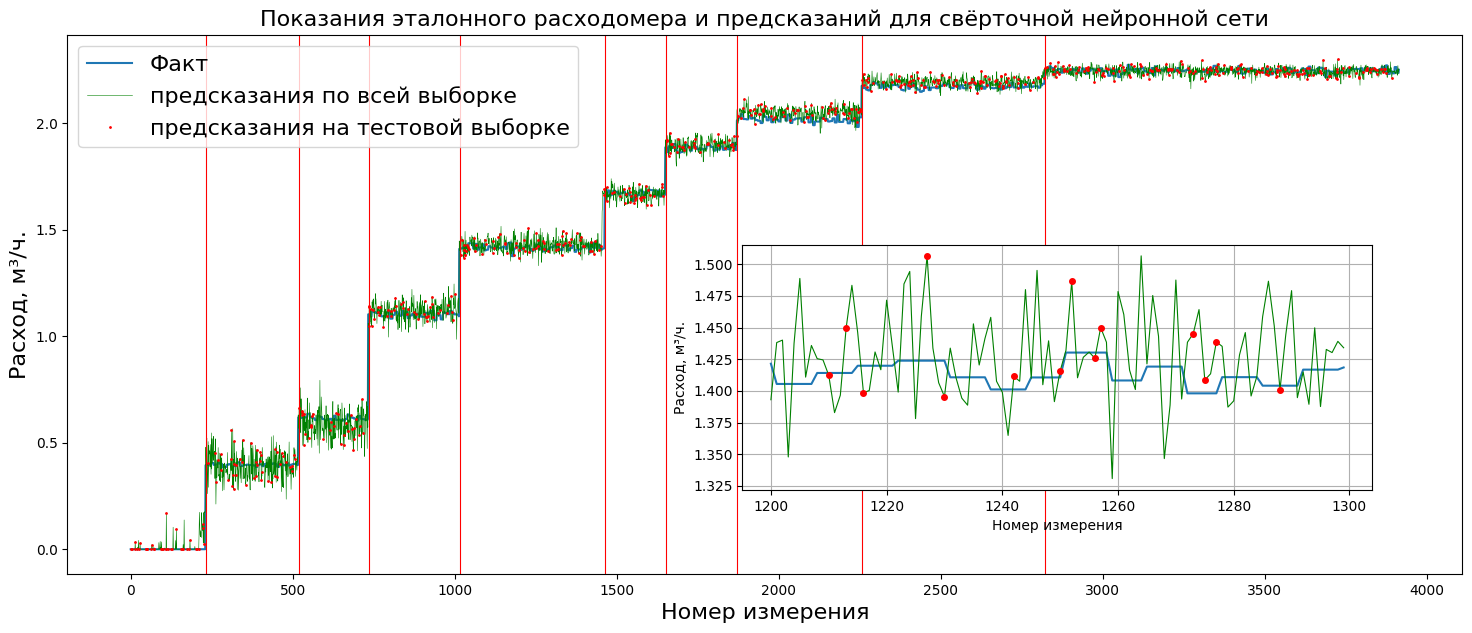

In [101]:
# Вывод графика с фактическими и предсказанными данными
plot_predict(Y, i_test, y_predict, y_predict_all, borders, text="свёрточной нейронной сети")

In [102]:
# Загружаем лучшую модель
best_model = keras.models.load_model("/content/Checkpoint_path.keras")

In [103]:
# вывод метрик
print("Тестовая выборка:")
best_model.evaluate(X_test,y_test)
print("Валидационная выборка:")
best_model.evaluate(X_val,y_val)
print("Тренировочная выборка:")
best_model.evaluate(X_train,y_train)
pass

Тестовая выборка:
20/20 [==============================] - 4s 124ms/step - loss: 0.0017 - root_mean_squared_error: 0.0416 - r2_score: 0.9967
Валидационная выборка:
25/25 [==============================] - 3s 119ms/step - loss: 0.0017 - root_mean_squared_error: 0.0414 - r2_score: 0.9967
Тренировочная выборка:
79/79 [==============================] - 12s 156ms/step - loss: 0.0015 - root_mean_squared_error: 0.0389 - r2_score: 0.9971


In [104]:
# предсказание модели на тестовых данных
y_predict = best_model.predict(X_test)

20/20 [==============================] - 3s 118ms/step


In [105]:
# предсказание модели на полных данных
y_predict_all = best_model.predict(X)

123/123 [==============================] - 17s 139ms/step


(array([  3.,   1.,   1.,  11.,   5.,  18.,  11.,  19.,  40.,  60.,  96.,
        180., 293., 476., 733., 596., 523., 356., 212., 126.,  62.,  36.,
         18.,   9.,   7.,   4.,   0.,   8.,   4.,   1.,   0.,   0.,   0.,
          1.,   3.,   2.]),
 array([-0.18611465, -0.17326367, -0.16041268, -0.1475617 , -0.13471071,
        -0.12185972, -0.10900874, -0.09615775, -0.08330676, -0.07045578,
        -0.05760479, -0.04475381, -0.03190282, -0.01905183, -0.00620085,
         0.00665014,  0.01950112,  0.03235211,  0.0452031 ,  0.05805408,
         0.07090507,  0.08375606,  0.09660704,  0.10945803,  0.12230901,
         0.13516   ,  0.14801099,  0.16086197,  0.17371296,  0.18656395,
         0.19941493,  0.21226592,  0.2251169 ,  0.23796789,  0.25081888,
         0.26366986,  0.27652085]),
 <BarContainer object of 36 artists>)

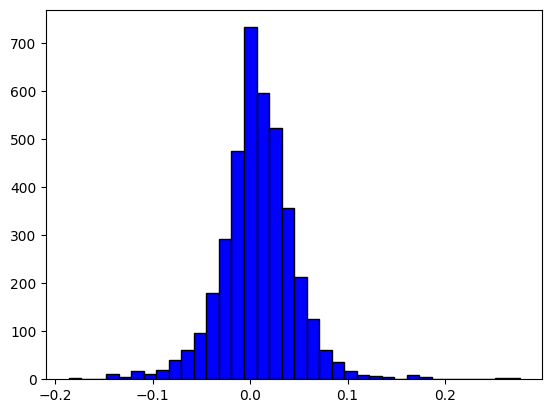

In [106]:
spo  = y_predict_all[:,0]-Y
plt.hist(spo, color = 'blue', edgecolor = 'black',
         bins = int(180/5))

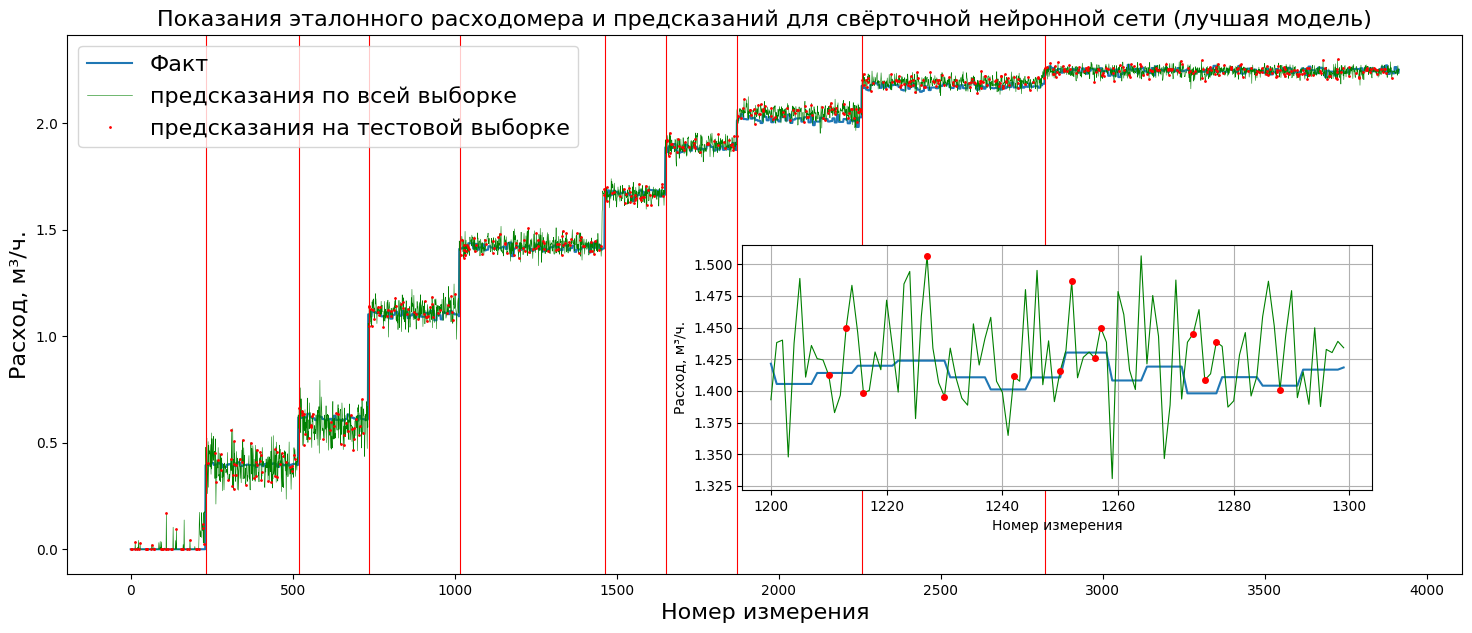

In [107]:
# Вывод графика с фактическими и предсказанными данными
plot_predict(Y, i_test, y_predict, y_predict_all, borders, text="свёрточной нейронной сети (лучшая модель)")

Проверим работу модели, приняв за тестовую выборку один из режимов расхода

In [108]:
# Новое разделение на тестовую, валидационную и обучающую выборки

l_ = len(Y)

_, _, _, _, i_val = my_test_train_split(X, Y, borders, test_size=0.2)

i_test = list(range(borders[3],borders[4]))

i_train = list(range(0,l_))
for x1 in i_test:
  i_train.remove(x1)
for x2 in i_val:
  try:
    i_train.remove(x2)
  except:
    i_ = 0

for x3 in i_test:
  try:
    i_val.remove(x3)
  except:
    i_ = 0

X_train = X[i_train,:,:]
y_train = Y[i_train]

X_val = X[i_val,:,:]
y_val = Y[i_val]

X_test = X[i_test,:,:]
y_test = Y[i_test]

In [109]:
# сброс весов модели
model.load_weights('model.h5')

In [110]:
# сброс лучшей модели
try:
    os.remove("/content/Checkpoint_path.keras")
except OSError:
    print("removing is failed")

In [111]:
# Обучение модели
history = model.fit(
    X_train, y_train, epochs=64, batch_size=64,
    callbacks=callback_list, validation_data=(X_val, y_val)
    )

Epoch 1/64
44/44 [==============================] - 36s 814ms/step - loss: 1.0434 - root_mean_squared_error: 1.0215 - r2_score: -0.8072 - val_loss: 0.7236 - val_root_mean_squared_error: 0.8506 - val_r2_score: -0.2522
Epoch 2/64
44/44 [==============================] - 35s 802ms/step - loss: 0.5045 - root_mean_squared_error: 0.7103 - r2_score: 0.1263 - val_loss: 0.5307 - val_root_mean_squared_error: 0.7285 - val_r2_score: 0.0817
Epoch 3/64
44/44 [==============================] - 36s 818ms/step - loss: 0.3477 - root_mean_squared_error: 0.5897 - r2_score: 0.3977 - val_loss: 0.2096 - val_root_mean_squared_error: 0.4578 - val_r2_score: 0.6373
Epoch 4/64
44/44 [==============================] - 38s 867ms/step - loss: 0.1318 - root_mean_squared_error: 0.3630 - r2_score: 0.7718 - val_loss: 0.0621 - val_root_mean_squared_error: 0.2491 - val_r2_score: 0.8926
Epoch 5/64
44/44 [==============================] - 38s 862ms/step - loss: 0.0402 - root_mean_squared_error: 0.2004 - r2_score: 0.9304 - v

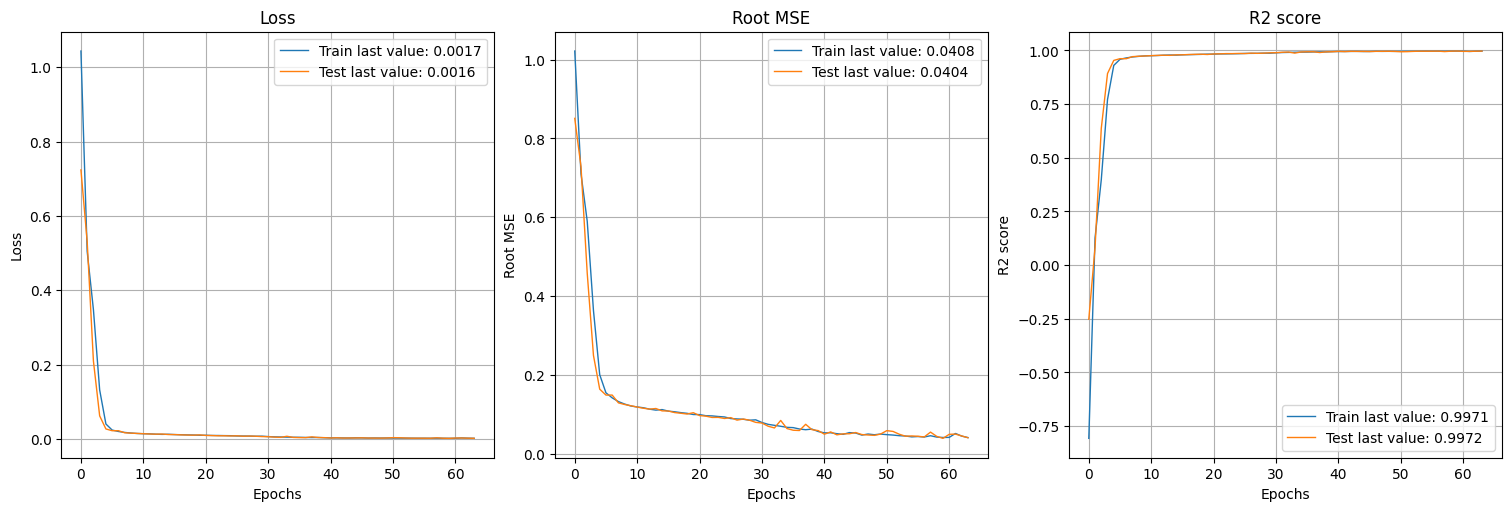

In [112]:
# вывод графиков с изменением метрик
show_history(history)
plot_history(history, path="standard.png")
plt.close()

In [113]:
# предсказание модели на тестовых данных
y_predict = model.predict(X_test)

15/15 [==============================] - 2s 148ms/step


In [114]:
# вывод метрик
print("Тестовая выборка:")
model.evaluate(X_test,y_test)
print("Валидационная выборка:")
model.evaluate(X_val,y_val)
print("Тренировочная выборка:")
model.evaluate(X_train,y_train)
pass

Тестовая выборка:
15/15 [==============================] - 2s 118ms/step - loss: 0.0062 - root_mean_squared_error: 0.0786 - r2_score: -22.7947
Валидационная выборка:
22/22 [==============================] - 3s 123ms/step - loss: 0.0016 - root_mean_squared_error: 0.0404 - r2_score: 0.9972
Тренировочная выборка:
87/87 [==============================] - 12s 138ms/step - loss: 0.0015 - root_mean_squared_error: 0.0387 - r2_score: 0.9974


In [115]:
# предсказание модели на полных данных
y_predict_all = model.predict(X)
print_scores(Y, y_predict_all, False)

123/123 [==============================] - 17s 134ms/step
Ошибка на тренировочных данных
MSE: 0.00206
RMSE: 0.04537
R2 : 0.99602


(array([  3.,   6.,   7.,   4.,  20.,  26.,  47.,  51.,  96., 155., 298.,
        627., 984., 515., 396., 316., 168.,  90.,  45.,  29.,  16.,   4.,
          3.,   1.,   0.,   1.,   1.,   1.,   0.,   1.,   1.,   1.,   1.,
          0.,   0.,   1.]),
 array([-0.2022236 , -0.18583426, -0.16944493, -0.15305559, -0.13666626,
        -0.12027692, -0.10388759, -0.08749825, -0.07110892, -0.05471958,
        -0.03833025, -0.02194091, -0.00555158,  0.01083776,  0.02722709,
         0.04361643,  0.06000576,  0.0763951 ,  0.09278443,  0.10917377,
         0.1255631 ,  0.14195244,  0.15834178,  0.17473111,  0.19112045,
         0.20750978,  0.22389912,  0.24028845,  0.25667779,  0.27306712,
         0.28945646,  0.30584579,  0.32223513,  0.33862446,  0.3550138 ,
         0.37140313,  0.38779247]),
 <BarContainer object of 36 artists>)

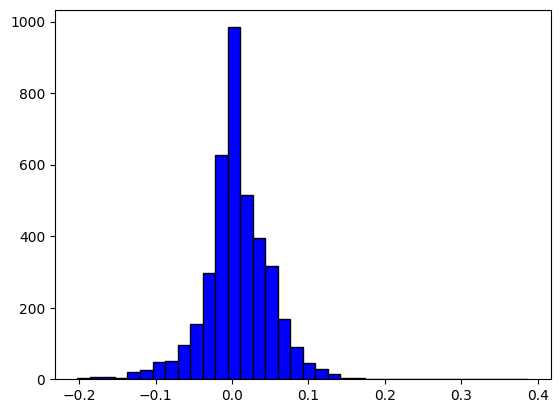

In [116]:
spo  = y_predict_all[:,0]-Y
plt.hist(spo, color = 'blue', edgecolor = 'black',
         bins = int(180/5))

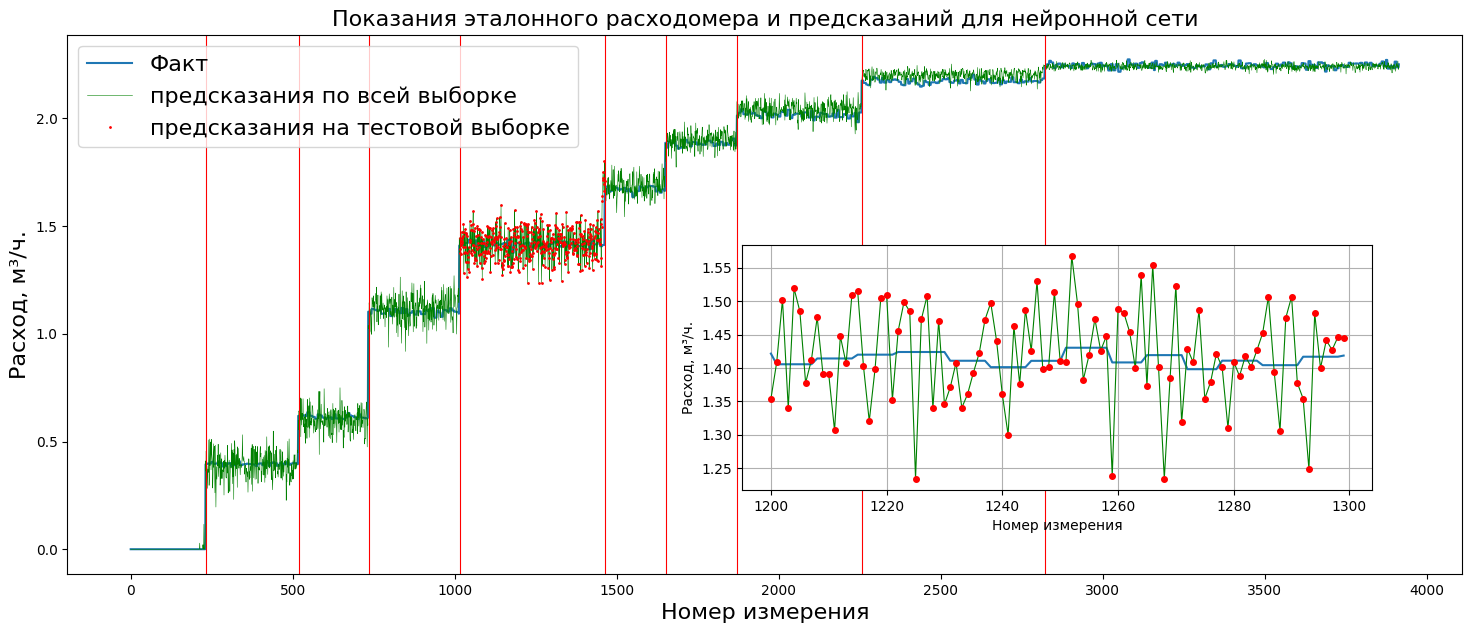

In [117]:
# Вывод графика с фактическими и предсказанными данными
plot_predict(Y, i_test, y_predict, y_predict_all, borders, text="нейронной сети")

In [118]:
best_model = keras.models.load_model("/content/Checkpoint_path.keras")

In [119]:
# вывод метрик
print("Тестовая выборка:")
best_model.evaluate(X_test,y_test)
print("Валидационная выборка:")
best_model.evaluate(X_val,y_val)
print("Тренировочная выборка:")
best_model.evaluate(X_train,y_train)
pass

Тестовая выборка:
15/15 [==============================] - 3s 122ms/step - loss: 0.0065 - root_mean_squared_error: 0.0805 - r2_score: -23.9399
Валидационная выборка:
22/22 [==============================] - 3s 124ms/step - loss: 0.0015 - root_mean_squared_error: 0.0388 - r2_score: 0.9974
Тренировочная выборка:
87/87 [==============================] - 14s 159ms/step - loss: 0.0014 - root_mean_squared_error: 0.0374 - r2_score: 0.9976


In [120]:
# предсказание модели на тестовых данных
y_predict = best_model.predict(X_test)

15/15 [==============================] - 4s 211ms/step


In [121]:
# предсказание модели на полных данных
y_predict_all = best_model.predict(X)

123/123 [==============================] - 16s 133ms/step


(array([  6.,   5.,   5.,   5.,  24.,  35.,  41.,  57., 103., 168., 381.,
        671., 698., 760., 391., 243., 146.,  73.,  43.,  26.,  16.,   5.,
          4.,   1.,   1.,   0.,   1.,   1.,   0.,   1.,   1.,   1.,   1.,
          0.,   0.,   1.]),
 array([-0.21065009, -0.19453753, -0.17842497, -0.16231242, -0.14619986,
        -0.13008731, -0.11397475, -0.09786219, -0.08174964, -0.06563708,
        -0.04952453, -0.03341197, -0.01729941, -0.00118686,  0.0149257 ,
         0.03103825,  0.04715081,  0.06326337,  0.07937592,  0.09548848,
         0.11160103,  0.12771359,  0.14382615,  0.1599387 ,  0.17605126,
         0.19216382,  0.20827637,  0.22438893,  0.24050148,  0.25661404,
         0.2727266 ,  0.28883915,  0.30495171,  0.32106426,  0.33717682,
         0.35328938,  0.36940193]),
 <BarContainer object of 36 artists>)

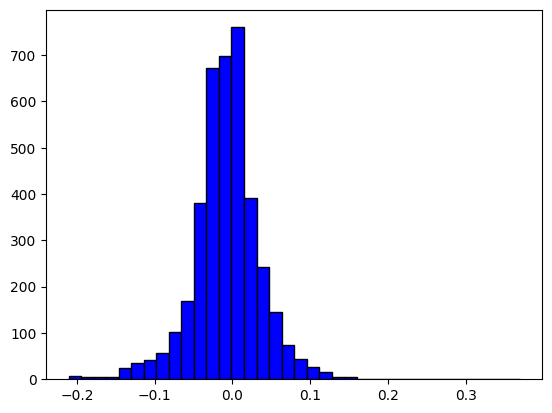

In [122]:
spo  = y_predict_all[:,0]-Y
plt.hist(spo, color = 'blue', edgecolor = 'black',
         bins = int(180/5))

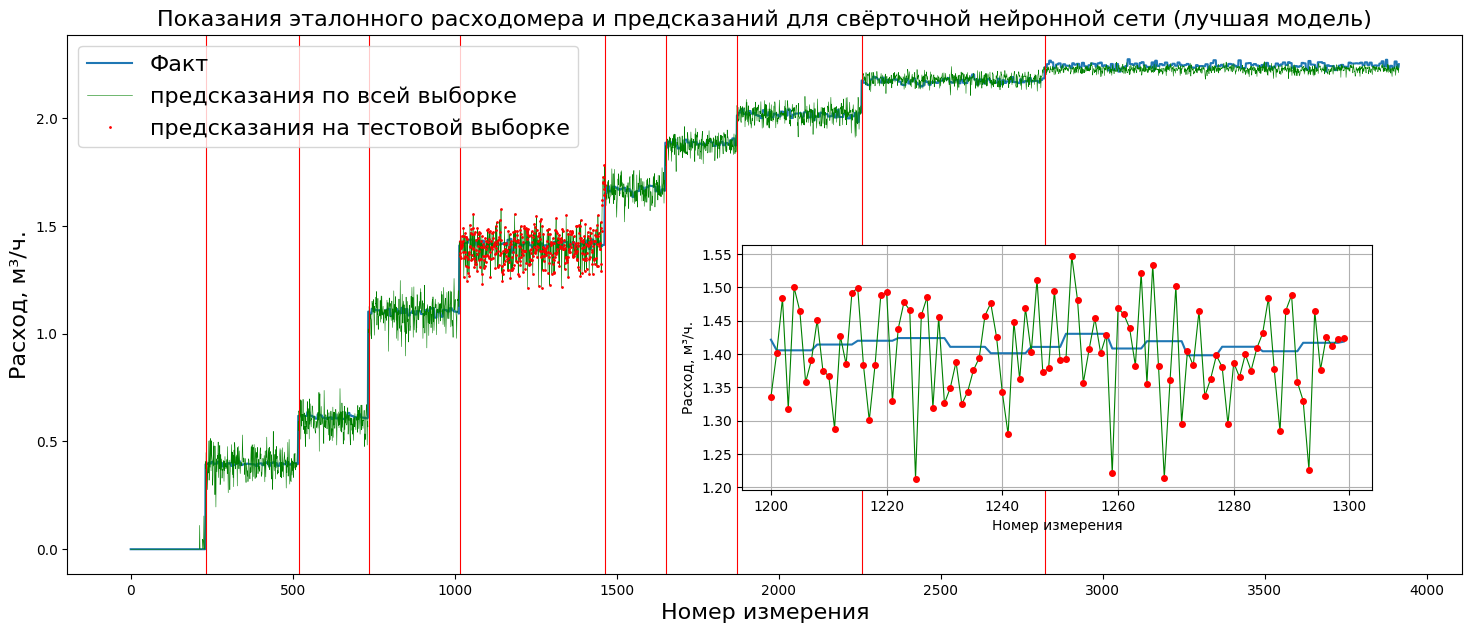

In [123]:
# Вывод графика с фактическими и предсказанными данными
plot_predict(Y, i_test, y_predict, y_predict_all, borders, text="свёрточной нейронной сети (лучшая модель)")

Построим нейронную сеть для данных, сглаженных фильтром Савцикого-Голея

In [140]:
from scipy.signal import savgol_filter
sig_up_sg = sig_up.apply(lambda x: savgol_filter(x,30,4), axis=0) # сглаженные сигналы 1-го пьезоэлектрического датчика
sig_dw_sg = sig_dw.apply(lambda x: savgol_filter(x,30,4), axis=0) # сглаженные сигналы 2-го пьезоэлектрического датчика

In [141]:
X = []

for i_x in range(sig_up.shape[0]):
  X_ = [sig_up_sg.iloc[i_x,:], sig_dw_sg.iloc[i_x,:]]
  X_ = list(map(list, zip(*X_)))
  X.append(X_)

X = np.array(X)

In [142]:
from scipy.signal import savgol_filter
sig_up_sg = sig_up.apply(lambda x: savgol_filter(x,30,4), axis=0) # сглаженные сигналы 1-го пьезоэлектрического датчика
sig_dw_sg = sig_dw.apply(lambda x: savgol_filter(x,30,4), axis=0) # сглаженные сигналы 2-го пьезоэлектрического датчика

In [143]:
# Разделение на выборки

Y = np.array(Y_['Et'])
input_dim = X.shape[1]

X_train, y_train, i_train, X_val, y_val, i_val, X_test, y_test, i_test =  my_test_val_train_split(X, Y, borders)

In [144]:
# изменение формата данных
X_train = tf.convert_to_tensor(X_train, np.float32)
X_test = tf.convert_to_tensor(X_test, np.float32)
X_val = tf.convert_to_tensor(X_val, np.float32)
y_train = tf.convert_to_tensor(y_train, np.float32)
y_val = tf.convert_to_tensor(y_val, np.float32)
y_test = tf.convert_to_tensor(y_test, np.float32)

In [145]:
# сброс весов модели
model.load_weights('model.h5')

# сброс лучшей модели
try:
    os.remove("/content/Checkpoint_path.keras")
except OSError:
    print("removing is failed")

removing is failed


In [146]:
# Обучение модели
history = model.fit(
    X_train, y_train, epochs=64, batch_size=64,
    callbacks=callback_list, validation_data=(X_val, y_val)
    )

Epoch 1/64
40/40 [==============================] - 38s 843ms/step - loss: 1.1380 - root_mean_squared_error: 1.0668 - r2_score: -1.1984 - val_loss: 1.2021 - val_root_mean_squared_error: 1.0964 - val_r2_score: -1.3312
Epoch 2/64
40/40 [==============================] - 32s 809ms/step - loss: 0.3640 - root_mean_squared_error: 0.6034 - r2_score: 0.2967 - val_loss: 0.8423 - val_root_mean_squared_error: 0.9178 - val_r2_score: -0.6335
Epoch 3/64
40/40 [==============================] - 33s 834ms/step - loss: 0.1704 - root_mean_squared_error: 0.4127 - r2_score: 0.6709 - val_loss: 0.4204 - val_root_mean_squared_error: 0.6484 - val_r2_score: 0.1848
Epoch 4/64
40/40 [==============================] - 32s 804ms/step - loss: 0.4912 - root_mean_squared_error: 0.7008 - r2_score: 0.0511 - val_loss: 0.4813 - val_root_mean_squared_error: 0.6938 - val_r2_score: 0.0666
Epoch 5/64
40/40 [==============================] - 35s 870ms/step - loss: 0.3396 - root_mean_squared_error: 0.5827 - r2_score: 0.3440 - 

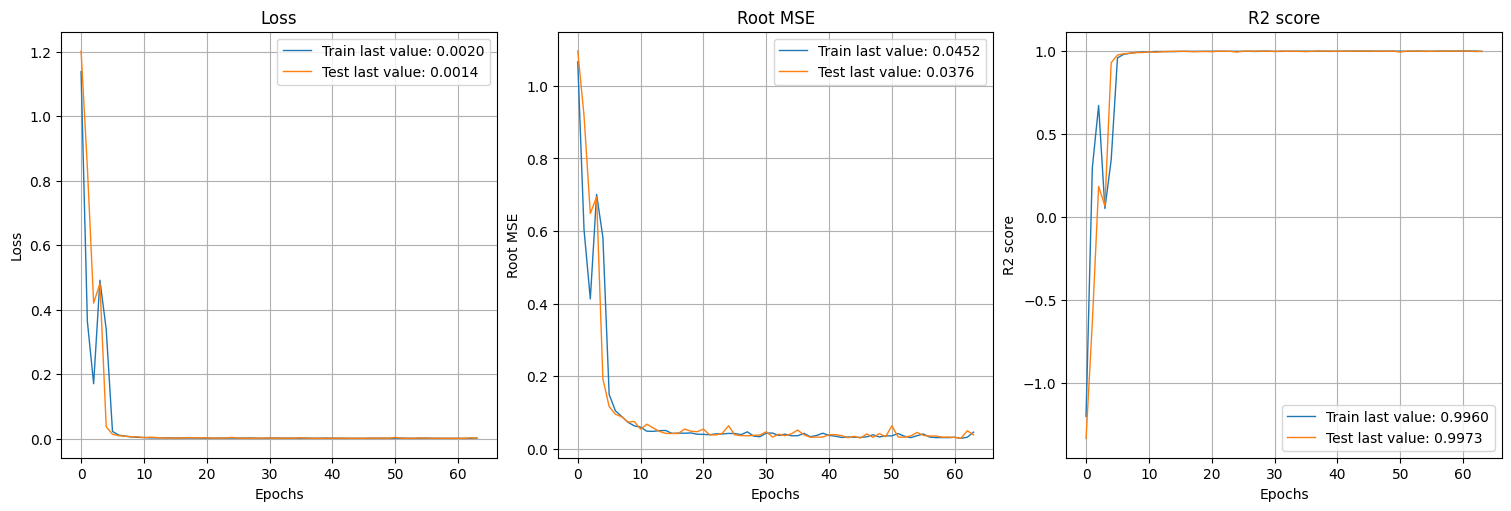

In [147]:
# вывод графиков с изменением метрик
show_history(history)
plot_history(history, path="standard.png")
plt.close()

In [148]:
# предсказание модели на тестовых данных
y_predict = model.predict(X_test)

20/20 [==============================] - 5s 199ms/step


In [149]:
# вывод метрик
print("Тестовая выборка:")
model.evaluate(X_test,y_test)
print("Валидационная выборка:")
model.evaluate(X_val,y_val)
print("Тренировочная выборка:")
model.evaluate(X_train,y_train)
pass

Тестовая выборка:
20/20 [==============================] - 3s 126ms/step - loss: 0.0013 - root_mean_squared_error: 0.0364 - r2_score: 0.9974
Валидационная выборка:
25/25 [==============================] - 4s 147ms/step - loss: 0.0014 - root_mean_squared_error: 0.0376 - r2_score: 0.9973
Тренировочная выборка:
79/79 [==============================] - 10s 129ms/step - loss: 0.0013 - root_mean_squared_error: 0.0359 - r2_score: 0.9975


In [150]:
# предсказание модели на полных данных
#X = X.reshape(X.shape[0], 2, 512,1)
y_predict_all = model.predict(X)
print_scores(Y, y_predict_all)

123/123 [==============================] - 18s 145ms/step
Ошибка на полных данных
MSE: 0.00132
RMSE: 0.03635
R2 : 0.99745


(array([  1.,   0.,   1.,   0.,   0.,   0.,   1.,   1.,   5.,   5.,   5.,
         16.,  59., 249., 611., 682., 795., 619., 442., 216., 118.,  41.,
         15.,   7.,   6.,   4.,   1.,   0.,   3.,   2.,   1.,   1.,   1.,
          2.,   2.,   3.]),
 array([-0.1869911 , -0.17436321, -0.16173533, -0.14910745, -0.13647956,
        -0.12385168, -0.1112238 , -0.09859591, -0.08596803, -0.07334015,
        -0.06071226, -0.04808438, -0.0354565 , -0.02282862, -0.01020073,
         0.00242715,  0.01505503,  0.02768292,  0.0403108 ,  0.05293868,
         0.06556657,  0.07819445,  0.09082233,  0.10345022,  0.1160781 ,
         0.12870598,  0.14133386,  0.15396175,  0.16658963,  0.17921751,
         0.1918454 ,  0.20447328,  0.21710116,  0.22972905,  0.24235693,
         0.25498481,  0.2676127 ]),
 <BarContainer object of 36 artists>)

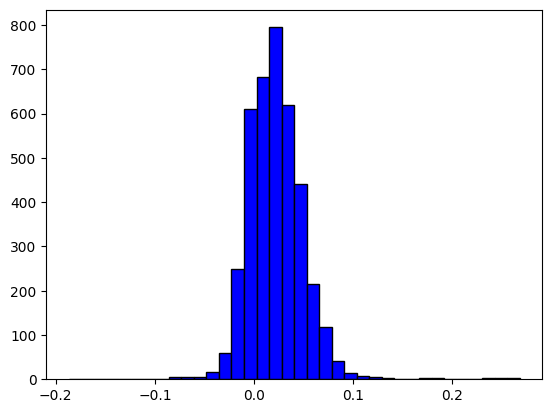

In [151]:
spo  = y_predict_all[:,0]-Y
plt.hist(spo, color = 'blue', edgecolor = 'black',
         bins = int(180/5))

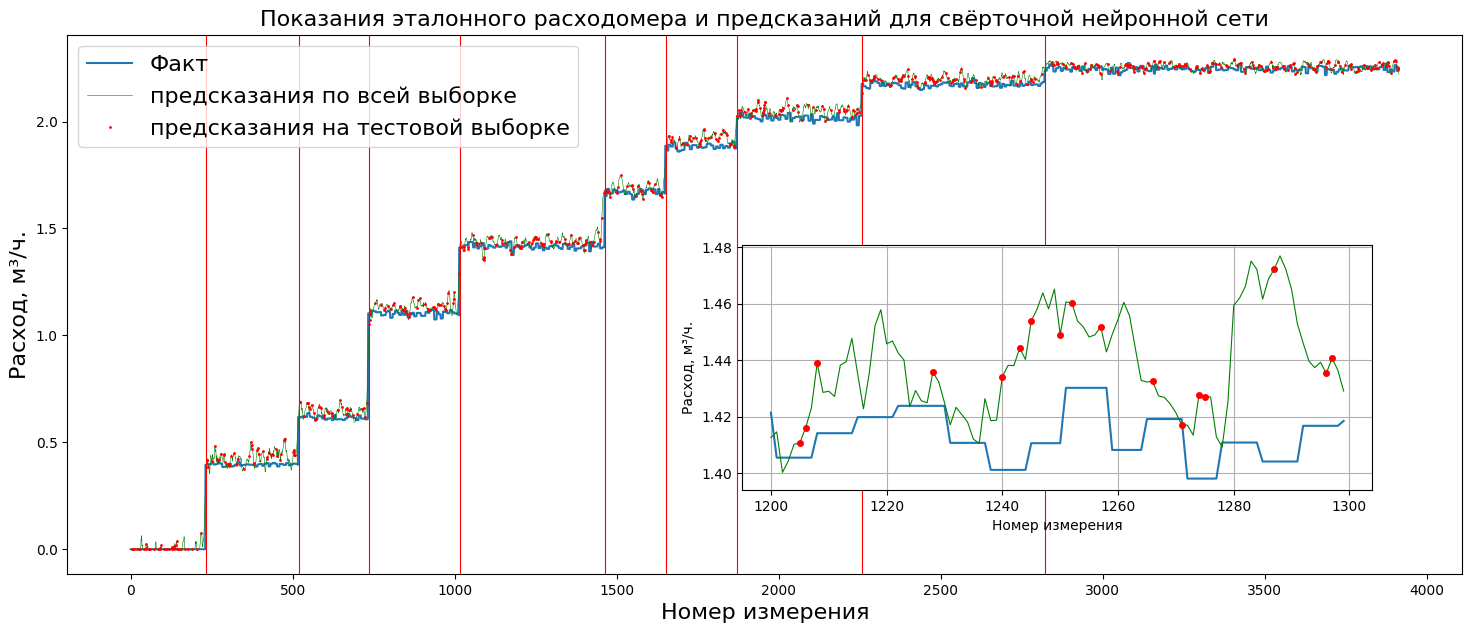

In [152]:
# Вывод графика с фактическими и предсказанными данными
plot_predict(Y, i_test, y_predict, y_predict_all, borders, text="свёрточной нейронной сети")

In [153]:
# Загружаем лучшую модель
best_model = keras.models.load_model("/content/Checkpoint_path.keras")

In [154]:
# вывод метрик
print("Тестовая выборка:")
best_model.evaluate(X_test,y_test)
print("Валидационная выборка:")
best_model.evaluate(X_val,y_val)
print("Тренировочная выборка:")
best_model.evaluate(X_train,y_train)
pass

Тестовая выборка:
20/20 [==============================] - 4s 126ms/step - loss: 6.6728e-04 - root_mean_squared_error: 0.0258 - r2_score: 0.9987
Валидационная выборка:
25/25 [==============================] - 4s 177ms/step - loss: 7.9443e-04 - root_mean_squared_error: 0.0282 - r2_score: 0.9985
Тренировочная выборка:
79/79 [==============================] - 11s 140ms/step - loss: 6.7470e-04 - root_mean_squared_error: 0.0260 - r2_score: 0.9987


In [155]:
# предсказание модели на тестовых данных
y_predict = best_model.predict(X_test)

20/20 [==============================] - 4s 196ms/step


In [156]:
# предсказание модели на полных данных
y_predict_all = best_model.predict(X)

123/123 [==============================] - 17s 135ms/step


(array([1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 2.000e+00, 4.000e+00, 3.000e+00, 7.000e+00,
        2.800e+01, 8.200e+01, 2.480e+02, 5.270e+02, 1.042e+03, 9.230e+02,
        5.630e+02, 2.790e+02, 1.300e+02, 4.200e+01, 8.000e+00, 1.000e+00,
        2.000e+00, 3.000e+00, 2.000e+00, 1.000e+00, 2.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 3.000e+00, 2.000e+00]),
 array([-0.20887315, -0.19621212, -0.18355108, -0.17089005, -0.15822901,
        -0.14556797, -0.13290694, -0.1202459 , -0.10758487, -0.09492383,
        -0.0822628 , -0.06960176, -0.05694072, -0.04427969, -0.03161865,
        -0.01895762, -0.00629658,  0.00636445,  0.01902549,  0.03168653,
         0.04434756,  0.0570086 ,  0.06966963,  0.08233067,  0.0949917 ,
         0.10765274,  0.12031378,  0.13297481,  0.14563585,  0.15829688,
         0.17095792,  0.18361895,  0.19627999,  0.20894103,  0.22160206,
         0.2342631 ,  0.24692413]),
 <BarCo

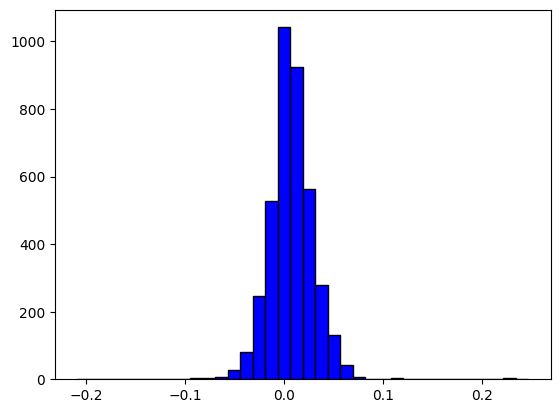

In [157]:
spo  = y_predict_all[:,0]-Y
plt.hist(spo, color = 'blue', edgecolor = 'black',
         bins = int(180/5))

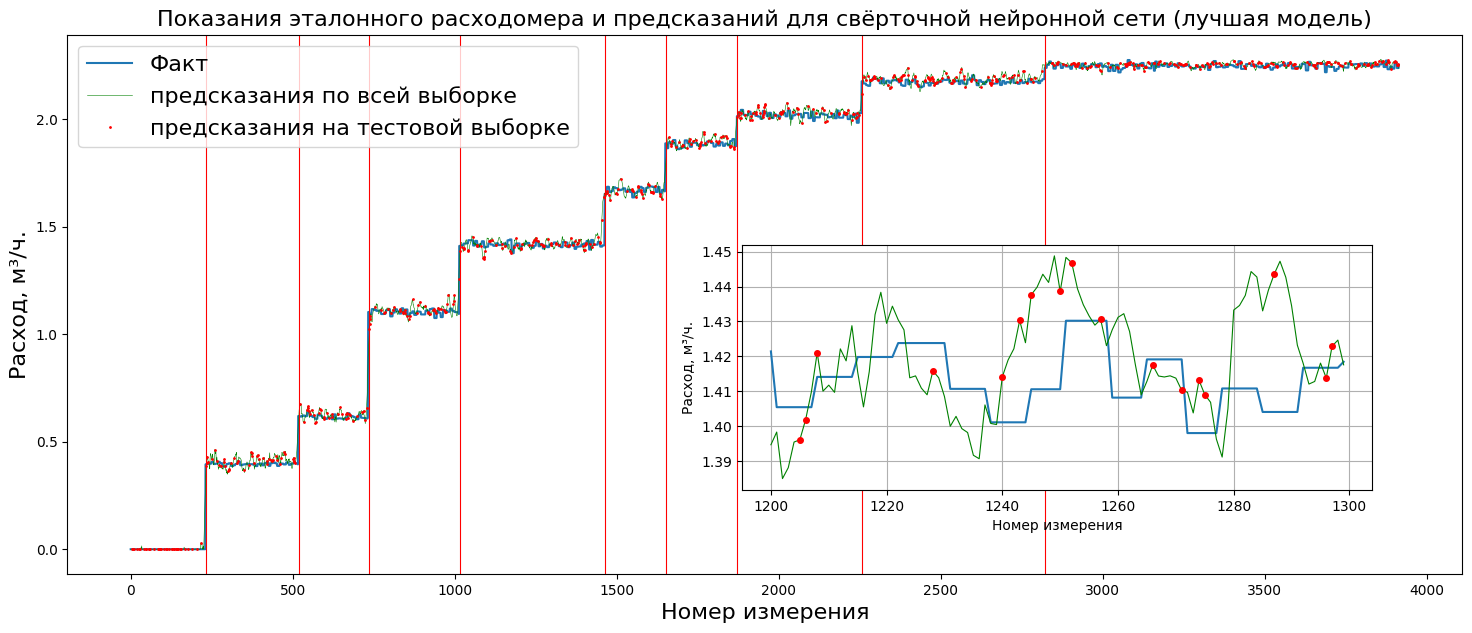

In [158]:
# Вывод графика с фактическими и предсказанными данными
plot_predict(Y, i_test, y_predict, y_predict_all, borders, text="свёрточной нейронной сети (лучшая модель)")

<h2>Проверим работу модели, приняв за тестовую выборку один из режимов расхода</h2>

In [159]:
# Новое разделение на тестовую, валидационную и обучающую выборки

l_ = len(Y)

_, _, _, _, i_val = my_test_train_split(X, Y, borders, test_size=0.2)

i_test = list(range(borders[3],borders[4]))

i_train = list(range(0,l_))
for x1 in i_test:
  i_train.remove(x1)
for x2 in i_val:
  try:
    i_train.remove(x2)
  except:
    i_ = 0

for x3 in i_test:
  try:
    i_val.remove(x3)
  except:
    i_ = 0

X_train = X[i_train,:,:]
y_train = Y[i_train]

X_val = X[i_val,:,:]
y_val = Y[i_val]

X_test = X[i_test,:,:]
y_test = Y[i_test]


In [160]:
# сброс весов модели
model.load_weights('model.h5')

In [161]:
# сброс лучшей модели
try:
    os.remove("/content/Checkpoint_path.keras")
except OSError:
    print("removing is failed")

In [171]:
# Обучение модели
history = model.fit(
    X_train, y_train, epochs=64, batch_size=64,
    callbacks=callback_list, validation_data=(X_val, y_val)
    )

Epoch 1/64
44/44 [==============================] - 43s 886ms/step - loss: 0.0031 - root_mean_squared_error: 0.0553 - r2_score: 0.9947 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0399 - val_r2_score: 0.9972
Epoch 2/64
44/44 [==============================] - 38s 866ms/step - loss: 0.0017 - root_mean_squared_error: 0.0415 - r2_score: 0.9970 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0412 - val_r2_score: 0.9971
Epoch 3/64
44/44 [==============================] - 39s 883ms/step - loss: 0.0018 - root_mean_squared_error: 0.0430 - r2_score: 0.9968 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0407 - val_r2_score: 0.9971
Epoch 4/64
44/44 [==============================] - 39s 881ms/step - loss: 0.0019 - root_mean_squared_error: 0.0433 - r2_score: 0.9968 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0420 - val_r2_score: 0.9969
Epoch 5/64
44/44 [==============================] - 40s 920ms/step - loss: 0.0020 - root_mean_squared_error: 0.0448 - r2_score: 0.9965 - val

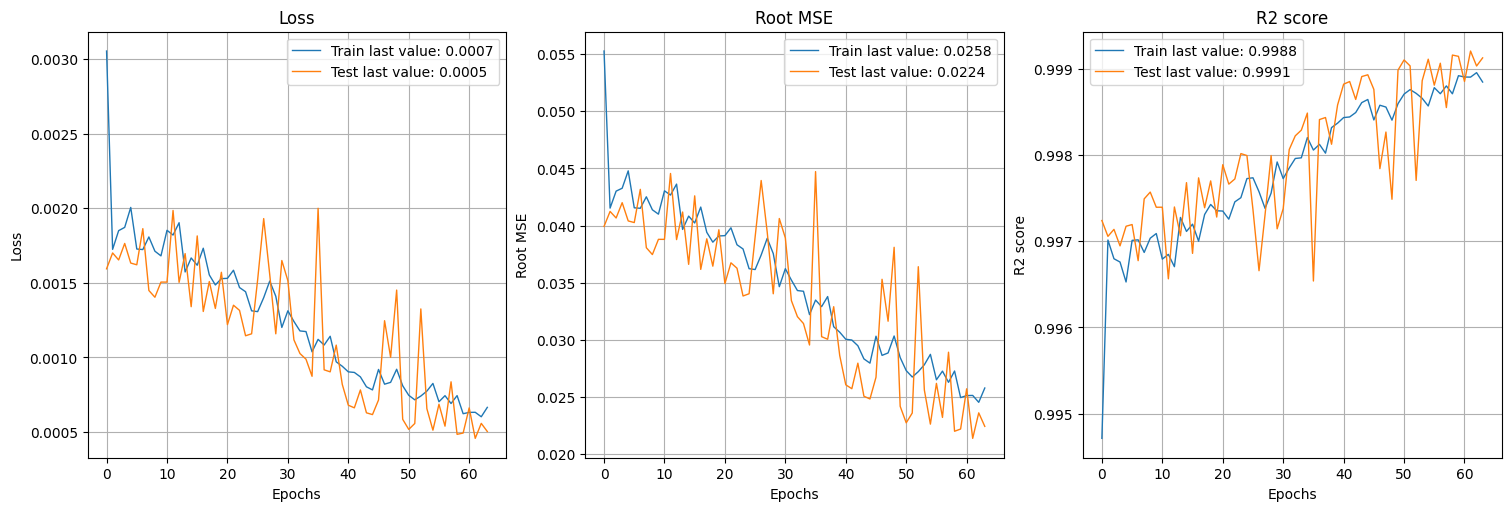

In [172]:
# вывод графиков с изменением метрик
show_history(history)
plot_history(history, path="standard.png")
plt.close()

In [173]:
# предсказание модели на тестовых данных
y_predict = model.predict(X_test)

15/15 [==============================] - 4s 191ms/step


In [174]:
# вывод метрик
print("Тестовая выборка:")
model.evaluate(X_test,y_test)
print("Валидационная выборка:")
model.evaluate(X_val,y_val)
print("Тренировочная выборка:")
model.evaluate(X_train,y_train)
pass

Тестовая выборка:
15/15 [==============================] - 2s 130ms/step - loss: 0.0029 - root_mean_squared_error: 0.0534 - r2_score: -10.0019
Валидационная выборка:
22/22 [==============================] - 3s 132ms/step - loss: 5.0360e-04 - root_mean_squared_error: 0.0224 - r2_score: 0.9991
Тренировочная выборка:
87/87 [==============================] - 13s 143ms/step - loss: 5.3673e-04 - root_mean_squared_error: 0.0232 - r2_score: 0.9991


In [175]:
# предсказание модели на полных данных
y_predict_all = model.predict(X)
print_scores(Y, y_predict_all, False)

123/123 [==============================] - 18s 148ms/step
Ошибка на тренировочных данных
MSE: 0.00080
RMSE: 0.02823
R2 : 0.99846


(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 2.000e+00, 4.000e+00, 6.000e+00, 9.000e+00, 1.800e+01,
        2.800e+01, 8.300e+01, 1.670e+02, 3.430e+02, 7.870e+02, 1.235e+03,
        7.050e+02, 3.260e+02, 1.370e+02, 3.400e+01, 1.200e+01, 2.000e+00,
        3.000e+00, 3.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 3.000e+00, 1.000e+00]),
 array([-0.25752193, -0.24278449, -0.22804706, -0.21330962, -0.19857219,
        -0.18383475, -0.16909731, -0.15435988, -0.13962244, -0.12488501,
        -0.11014757, -0.09541014, -0.0806727 , -0.06593527, -0.05119783,
        -0.03646039, -0.02172296, -0.00698552,  0.00775191,  0.02248935,
         0.03722678,  0.05196422,  0.06670165,  0.08143909,  0.09617652,
         0.11091396,  0.1256514 ,  0.14038883,  0.15512627,  0.1698637 ,
         0.18460114,  0.19933857,  0.21407601,  0.22881344,  0.24355088,
         0.25828832,  0.27302575]),
 <BarCo

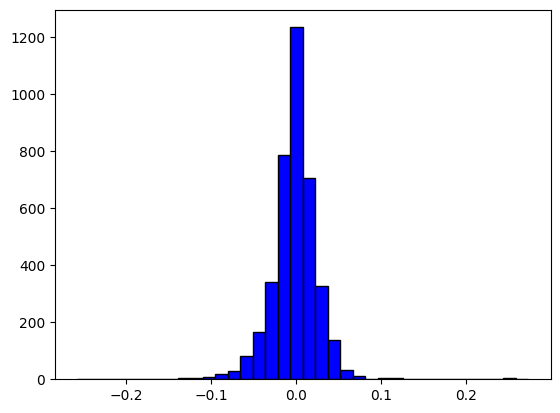

In [176]:
spo  = y_predict_all[:,0]-Y
plt.hist(spo, color = 'blue', edgecolor = 'black',
         bins = int(180/5))

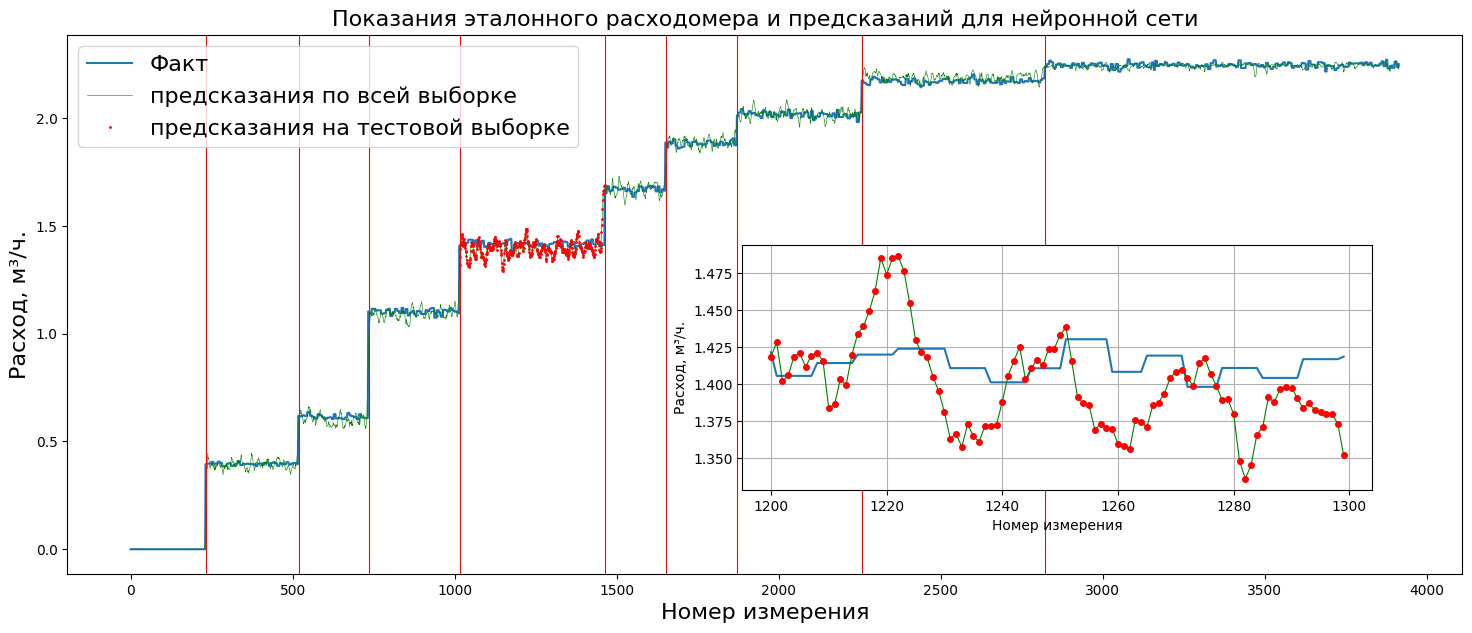

In [177]:
# Вывод графика с фактическими и предсказанными данными
plot_predict(Y, i_test, y_predict, y_predict_all, borders, text="нейронной сети")

In [178]:
best_model = keras.models.load_model("/content/Checkpoint_path.keras")

In [179]:
# вывод метрик
print("Тестовая выборка:")
best_model.evaluate(X_test,y_test)
print("Валидационная выборка:")
best_model.evaluate(X_val,y_val)
print("Тренировочная выборка:")
best_model.evaluate(X_train,y_train)
pass

Тестовая выборка:
15/15 [==============================] - 4s 125ms/step - loss: 0.0026 - root_mean_squared_error: 0.0509 - r2_score: -8.9915
Валидационная выборка:
22/22 [==============================] - 3s 134ms/step - loss: 4.5767e-04 - root_mean_squared_error: 0.0214 - r2_score: 0.9992
Тренировочная выборка:
87/87 [==============================] - 12s 141ms/step - loss: 5.1966e-04 - root_mean_squared_error: 0.0228 - r2_score: 0.9991


In [180]:
# предсказание модели на тестовых данных
y_predict = best_model.predict(X_test)

15/15 [==============================] - 4s 196ms/step


In [181]:
# предсказание модели на полных данных
y_predict_all = best_model.predict(X)

123/123 [==============================] - 17s 141ms/step


(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        2.000e+00, 1.000e+00, 6.000e+00, 6.000e+00, 1.100e+01, 2.100e+01,
        4.300e+01, 1.110e+02, 2.920e+02, 6.880e+02, 1.248e+03, 7.890e+02,
        4.060e+02, 1.800e+02, 5.800e+01, 2.500e+01, 1.000e+01, 2.000e+00,
        2.000e+00, 3.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 3.000e+00, 1.000e+00]),
 array([-0.24240029, -0.22793539, -0.21347049, -0.19900558, -0.18454068,
        -0.17007578, -0.15561088, -0.14114598, -0.12668108, -0.11221617,
        -0.09775127, -0.08328637, -0.06882147, -0.05435657, -0.03989167,
        -0.02542677, -0.01096186,  0.00350304,  0.01796794,  0.03243284,
         0.04689774,  0.06136264,  0.07582755,  0.09029245,  0.10475735,
         0.11922225,  0.13368715,  0.14815205,  0.16261695,  0.17708186,
         0.19154676,  0.20601166,  0.22047656,  0.23494146,  0.24940636,
         0.26387127,  0.27833617]),
 <BarCo

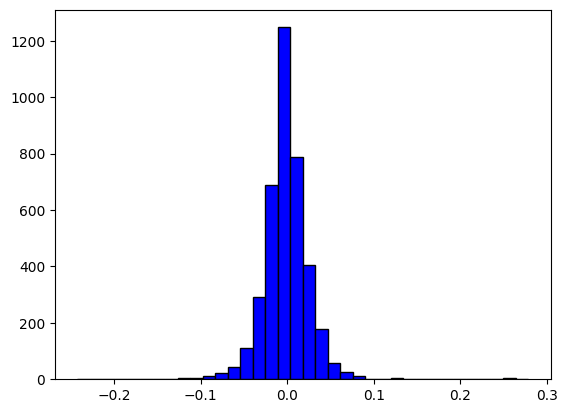

In [182]:
spo  = y_predict_all[:,0]-Y
plt.hist(spo, color = 'blue', edgecolor = 'black',
         bins = int(180/5))

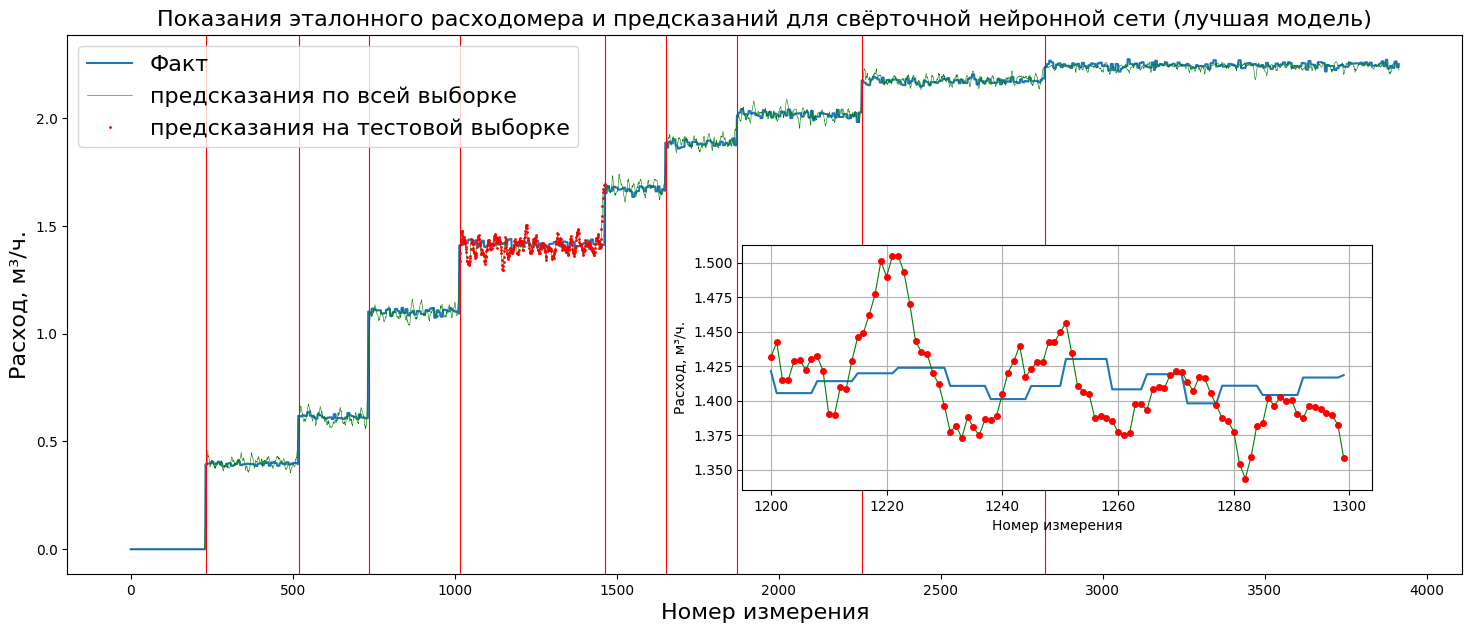

In [183]:
# Вывод графика с фактическими и предсказанными данными
plot_predict(Y, i_test, y_predict, y_predict_all, borders, text="свёрточной нейронной сети (лучшая модель)")

In [184]:
#del[model]